In [1]:
import sys
import numpy as np 
import pandas as pd
import random
import math 
import timeit
import matplotlib.pyplot as plt

In [2]:
def file_input(file):
    train_x = data_parse("train-" + file)
    train_y = reg_parse("trainR-" + file)
    train_y = np.matrix.transpose(train_y)
    test_x = data_parse("test-" + file)
    test_y = reg_parse("testR-" + file)
    test_y = np.matrix.transpose(test_y)
    return train_x, train_y, test_x, test_y

def data_parse(file):
    x1 = []
    with open(file,'r') as f:
        lines = [lines for lines in f.read().split("\n")][:-1]
        for each_line in lines:
            each_line = [float(value) for value in each_line.split(",")]
            x1.append(each_line)
    return np.asmatrix(x1)

def reg_parse(file):
    y1 = []
    with open(file,'r') as f:
        lines = [lines for lines in f.read().split("\n")][:-1]
        for each_line in lines:
            y1.append(float(each_line))    
    return np.asmatrix(y1)

In [3]:
def linearkernel(fi):
    fi_t = np.transpose(fi)
    linker = np.dot(fi,fi_t)
    linker = linker + 1
    return linker

def linearkernel1(test_x, train_x):
    initial = np.matmul(test_x, np.transpose(train_x))
    kernel = initial + 1
    return kernel

def mse(test_x, test_y, mn):
    sumation = 0
    for i in range(len(test_y)):
        sumation  += np.power((mn[i][0] - test_y[i]), 2)
    mse = sumation/len(test_y) 
    return mse.tolist()[0][0]

def rbfkernel(x1,x2,s):
    exp = np.zeros((len(x1),len(x2)))
    for o in range(len(x1)):
        for p in range(len(x2)):
            e = (np.linalg.norm((x1[o]-x2[p]),2)/np.power(s,2))
            exp[o][p] = np.exp(-0.5*e)
    return exp

def covariance(fi, kernel, alpha, beta):
    cov = (kernel/alpha) + (np.identity(fi.shape[0])/beta)
    return cov 

def cov1(kernel, alpha, beta):
    cov = (kernel/alpha) + (1/beta)
    return cov 

def covariance1(alpha, kernel):
    cov = kernel/alpha
    return cov

def v_t(test_x, train_x, alpha, beta, kernel):
    v_t = []
    for i in range(len(test_x)):
        vt = covariance1(alpha, linearkernel1(test_x[i], train_x))
        v_t.append(vt)
    final_vt = np.squeeze(np.asarray(v_t))
    return final_vt

def mean(train_x, vt, train_y, alpha, beta):
    cov = covariance(train_x, linearkernel(train_x), alpha, beta)
    mean = np.matmul(np.matmul(vt, np.linalg.inv(cov)), train_y)
    mean = mean.tolist()
    return mean

def v_i(train_x, test_x, vt, alpha, beta):   
    c = []
    cov = covariance(train_x, alpha , beta, linearkernel1(train_x, train_x))
    for i in range(len(test_x)):
        c_s = cov1(linearkernel1(test_x[i], test_x[i]), alpha, beta)
        c.append(c_s)
    c_train = covariance(train_x, linearkernel(train_x), alpha, beta)
    c_inv = np.linalg.inv(c_train)
    vi = np.asarray(c).reshape(-1,1) - np.dot(np.dot(vt, c_inv), np.transpose(vt))
    vi = np.diag(vi)
    return vi

def mn_ll(test_y, mn, vi):
    mnll = 0
    n = len(test_y)
    for i in range(n):
        val = np.exp((-0.5*(test_y[i] - mn[i][0])**2)/vi[i])
        mnll += -1*(np.log(val/np.sqrt((2*np.pi)*vi[i])))
    return mnll/n

In [4]:
def model_selection(fi, t, test_x, test_y, kernel):
    alpha = 1
    s = 5
    beta = 1
    mnll = []
    iteration = 0
    prev_ev = -9999
    n = 0.01
    c = 1
    der_cov_s = np.empty((len(fi),len(fi)))
    res = []
    I = np.identity(fi.shape[0])
    if (kernel == "linear"):
        kernel = linearkernel(fi)
        # changes start
    elif (kernel == "rbf"):
        kernel = rbfkernel(fi,fi,s)
        # change ends
    for k in range(0,100):
        #mse_p1 = mi - test_y
        cn = covariance(fi, kernel, alpha, beta)
        cn_inv = np.linalg.inv(cn)
        # Calculating values for alpha
        der_cov_alpha = (-1/(alpha)**2) * kernel
        # Calculating values for beta
        der_cov_beta = (-1/(beta)**2) * I
        # Calculating for s                    # changes start
        for i in range(len(fi)):
            for j in range(len(fi)):
                z = np.linalg.norm((fi[i]-fi[j]),2)/np.power(s,2)
                v = np.exp(-0.5 * z)
                der_cov_s[i][j] = np.dot(v, np.linalg.norm((fi[i]-fi[j]),2)) * (1/(s ** 3))
        # Calculating log evidence wrt s      
        log_ev_s = (-0.5 * (np.trace(np.dot(cn_inv, der_cov_s)))) + (0.5 * (np.dot((np.dot(np.transpose(train_y),cn_inv)),(np.dot(der_cov_s, np.dot(cn_inv, train_y))))))
        s1 = np.log(s)
        log_ev_s1 = (log_ev_s) * s
        c1 = s1 + (n * log_ev_s1)
        s = math.exp(c1)
        # Calculating log evidence wrt alpha
        log_ev_alpha = (-0.5 * (np.trace(np.dot(cn_inv, der_cov_alpha)))) + (0.5 * (np.dot((np.dot(np.transpose(train_y),cn_inv)),(np.dot(der_cov_alpha, np.dot(cn_inv, train_y))))))
        # Calculating log evidence wrt beta
        log_ev_beta = (-0.5 * (np.trace(np.dot(cn_inv, der_cov_beta)))) + (0.5 * (np.dot((np.dot(np.transpose(train_y),cn_inv)),(np.dot(der_cov_beta ,np.dot(cn_inv, train_y))))))
        # Computing values for ln(alpha) and ln(beta)
        a = np.log(alpha)
        b = np.log(beta)
        # Calculate values log evidence wrt to a 
        log_ev_a = (log_ev_alpha) * alpha
        # Calculate values log evidence wrt to b
        log_ev_b = (log_ev_beta) * beta
        a1 = a + (n * log_ev_a)
        b1 = b + (n * log_ev_b)
        alpha = math.exp(a1)
        beta = math.exp(b1)
        new_ev = - ((len(fi))*np.log10(2*np.pi)/2) - (0.5 * np.log(np.linalg.det(cn))) - (0.5 * np.matmul(np.matmul(np.transpose(t), np.linalg.inv(cn)), t)) 
        c = (new_ev - prev_ev)/abs(prev_ev)
        iteration = k
        prev_ev = new_ev
        vt = v_t(test_x, train_x, alpha, beta, linearkernel1(test_x, train_x))
        mn = mean(train_x, vt, train_y, alpha, beta)
        vi = v_i(train_x, test_x, vt, alpha, beta)
        if k%10 == 0:
            mnl_l = mn_ll(test_y, mn, vi).tolist()[0][0]
            mnll.append(mnl_l)
        if (c < 10 ** -5):
            mnl_l = mn_ll(test_y, mn, vi).tolist()[0][0]
            mnll.append(mnl_l)
            break
    res.append((alpha,beta,s,iteration,mnll))
    return res[0]

In [5]:
train_x, train_y, test_x, test_y= file_input("housing.csv")
alpha, beta, s, iteration, mnll= model_selection(train_x, train_y, test_x, test_y,"linear")

In [6]:
vt = v_t(test_x, train_x, alpha, beta, linearkernel1(test_x, train_x))
mn = mean(train_x, vt, train_y, alpha, beta)
vi = v_i(train_x, test_x, vt, alpha, beta)
mi = mse(test_x, test_y, mn)

Alpha: 21.362430093577444
Beta 3.9953439618043567
mse 0.28838117437697014


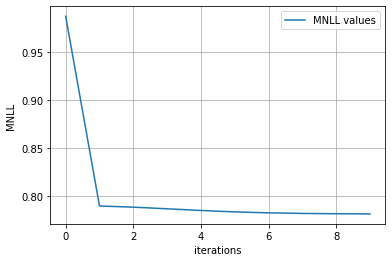

In [7]:
print("Alpha:",alpha)
print("Beta", beta)
print("mse",mi)
x = range(len(mnll))
plt.plot(x,mnll,label = "MNLL values")
plt.xlabel('iterations')
plt.ylabel('MNLL ')
plt.legend()
plt.grid(True)
plt.legend(loc='upper right')
plt.show()